<a href="https://colab.research.google.com/github/baosago/AIO-SmallGroup/blob/main/250703_Upgrade_RAG_Chatbot_English_Vietnamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Chatbot

## **Download a file**

In [1]:
!nvidia-smi

Thu Jul  3 05:40:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# https://drive.google.com/file/d/1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx/view?usp=drive_link
!gdown 1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx

Downloading...
From: https://drive.google.com/uc?id=1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx
To: /content/YOLOv10_Tutorials.pdf
100% 16.6M/16.6M [00:00<00:00, 32.1MB/s]


## **Install and import libraries**

In [3]:
!pip install -q transformers==4.52.4
!pip install -q bitsandbytes==0.46.0
!pip install -q accelerate==1.7.0
!pip install -q langchain==0.3.25
!pip install -q langchainhub==0.1.21
!pip install -q langchain-chroma==0.2.4
!pip install -q langchain_experimental==0.3.4
!pip install -q langchain-community==0.3.24
!pip install -q langchain_huggingface==0.2.0
!pip install -q python-dotenv==1.1.0
!pip install -q pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
import torch

from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline

from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.chains import ConversationalRetrievalChain
from langchain_experimental.text_splitter import SemanticChunker

from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

## **Read the pdf file**

In [5]:
#Tai file pdf
Loader = PyPDFLoader
FILE_PATH = "/content/YOLOv10_Tutorials.pdf"

loader = Loader(FILE_PATH)
documents = loader.load()


# Loader = PyPDFLoader
# FILE_PATH = "./YOLOv10_Tutorials.pdf"
# loader = Loader(FILE_PATH)
# documents = loader.load()

# print("Number of documents: ", len(documents))
# documents[0]

In [6]:
documents[0]

Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-06-20T11:06:10+00:00', 'author': '', 'keywords': '', 'moddate': '2024-06-20T11:06:10+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': 'Overleaf Example', 'trapped': '/False', 'source': '/content/YOLOv10_Tutorials.pdf', 'total_pages': 20, 'page': 0, 'page_label': '1'}, page_content='AI VIET NAM – AI COURSE 2024\nTutorial: Phát hiện đối tượng trong ảnh với\nYOLOv10\nDinh-Thang Duong, Nguyen-Thuan Duong, Minh-Duc Bui và\nQuang-Vinh Dinh\nNgày 20 tháng 6 năm 2024\nI. Giới thiệu\nObject Detection (Tạm dịch: Phát hiện đối tượng)là một bài toán cổ điển thuộc lĩnh vực\nComputer Vision. Mục tiêu của bài toán này là tự động xác định vị trí của các đối tượng trong\nmột tấm ảnh. Tính tới thời điểm hiện tại, đã có rất nhiều phương pháp được phát triển nhằm\ngiải quyết hiệu quả bài toán này. Trong đó, các 

## **Initialize text vectorization (embedding)**

In [7]:
embeddings = HuggingFaceEmbeddings(
    model_name = "bkai-foundation-models/vietnamese-bi-encoder"
)
# embeddings = HuggingFaceEmbeddings(
#     model_name="bkai-foundation-models/vietnamese-bi-encoder"
# )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

In [8]:
embeddings

HuggingFaceEmbeddings(model_name='bkai-foundation-models/vietnamese-bi-encoder', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

## **Initialize text splitter and split document**

In [9]:
# Split documents into semantic chunkers
semantic_splitter = SemanticChunker(
    embeddings=embeddings,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=95,
    min_chunk_size=500, #1000
    add_start_index=True
)

In [10]:
docs = semantic_splitter.split_documents(documents)

In [11]:
len(docs)

32

In [12]:
docs[1]

Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-06-20T11:06:10+00:00', 'author': '', 'keywords': '', 'moddate': '2024-06-20T11:06:10+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': 'Overleaf Example', 'trapped': '/False', 'source': '/content/YOLOv10_Tutorials.pdf', 'total_pages': 20, 'page': 1, 'page_label': '2', 'start_index': 0}, page_content='AI VIETNAM (AIO2024) aivietnam.edu.vn\nHình 2: Hiệu suất của YOLOv10 khi so sánh với các mô hình khác. Trên tập dữ liệu COCO,\nYOLOv10 đạt được kết quả tốt nhất về khía cạnh Độ trễ (Latency) và Số lượng tham số mô\nhình (Number of parameters) trong khi vẫn giữ được độ chính xác (COCO AP) cao. Ảnh: [10]. Trong bài viết này, chúng ta sẽ cùng nhau tìm hiểu về YOLOv10 và cách sử dụng mô hình này. Thông qua đó, nhóm cũng sẽ trình bày sơ lược về bài toán Object Detection cũng như tóm tắt\nngắn gọn các p

In [13]:
# Save all the semantic chunks as  vectors into the vector database
vector_db = Chroma.from_documents(
    documents=docs,
    embedding=embeddings
)

retriever = vector_db.as_retriever()

In [14]:
QUERY = "YOLOv10 dùng để làm gì?"

result = retriever.invoke(QUERY)

In [15]:
len(result)

4

In [16]:
result[0]

Document(id='8e92c7b4-3acb-4f47-ac69-22cb1454dd79', metadata={'page': 1, 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'total_pages': 20, 'moddate': '2024-06-20T11:06:10+00:00', 'trapped': '/False', 'title': 'Overleaf Example', 'start_index': 0, 'author': '', 'creationdate': '2024-06-20T11:06:10+00:00', 'source': '/content/YOLOv10_Tutorials.pdf', 'keywords': '', 'producer': 'pdfTeX-1.40.25', 'page_label': '2', 'subject': '', 'creator': 'LaTeX with hyperref'}, page_content='AI VIETNAM (AIO2024) aivietnam.edu.vn\nHình 2: Hiệu suất của YOLOv10 khi so sánh với các mô hình khác. Trên tập dữ liệu COCO,\nYOLOv10 đạt được kết quả tốt nhất về khía cạnh Độ trễ (Latency) và Số lượng tham số mô\nhình (Number of parameters) trong khi vẫn giữ được độ chính xác (COCO AP) cao. Ảnh: [10]. Trong bài viết này, chúng ta sẽ cùng nhau tìm hiểu về YOLOv10 và cách sử dụng mô hình này. Thông qua đó, nhóm cũng sẽ trình bày sơ lược về bài toán Object

In [17]:
# semantic_splitter = SemanticChunker(
#     embeddings=embeddings,
#     buffer_size=1,                          # Nhóm 3 câu
#     breakpoint_threshold_type="percentile",
#     breakpoint_threshold_amount=95,
#     # number_of_chunks= 30,                   # Số chunks mong muốn. Tìm number_of_chunks - 1 điểm có similarity thấp nhất để cắt. Nếu không đủ điểm cắt phù hợp → số chunks thực tế ≠ số chunks mong muốn
#     min_chunk_size=500,                     # Tối thiểu 1000 ký tự
#     # sentence_split_regex=r'(?<=[.?!…])\s+', # Bao gồm dấu … cho tiếng Việt
#     add_start_index=True
# )

# docs = semantic_splitter.split_documents(documents)
# print("Number of semantic chunks: ", len(docs))

In [18]:
print(docs[5])
print()
print(docs[6])
print()
print(docs[7])

page_content='Ảnh: Zixuan Zhang. 4' metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-06-20T11:06:10+00:00', 'author': '', 'keywords': '', 'moddate': '2024-06-20T11:06:10+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': 'Overleaf Example', 'trapped': '/False', 'source': '/content/YOLOv10_Tutorials.pdf', 'total_pages': 20, 'page': 3, 'page_label': '4', 'start_index': 739}

page_content='AI VIETNAM (AIO2024) aivietnam.edu.vn
- Điểm mới: Sử dụng anchor boxes, mạng Darknet-19, và tăng training data để tăng độ
chính xác. - Ưu điểm: Tăng độ chính xác và khả năng nhận diện nhiều object trong 1 cell. - Nhược điểm: Phức tạp hơn, cần nhiều tài nguyên tính toán, và khó detect các object
nhỏ. II.IV. YOLOv3
YOLOv3 [3] ra mắt năm 2018, tiếp tục cải tiến từ YOLOv2. Hình 6: Kiến trúc mô hình YOLOv3. Ảnh: [3]. - Điểm mới: Sử dụng mạng Darknet-53 và detect object ở ba

## **Create vector database and retriever**

In [19]:
# vector_db = Chroma.from_documents(
#     documents=docs,
#     embedding=embeddings)

# retriever = vector_db.as_retriever()

# QUERY = "YOLOv10 dùng để làm gì"
# result = retriever.invoke(QUERY)

# print("Number of relevant documents: ", len(result))

In [20]:
print(result[0])
print()
print(result[1])
print()
print(result[2])
print()
print(result[3])

page_content='AI VIETNAM (AIO2024) aivietnam.edu.vn
Hình 2: Hiệu suất của YOLOv10 khi so sánh với các mô hình khác. Trên tập dữ liệu COCO,
YOLOv10 đạt được kết quả tốt nhất về khía cạnh Độ trễ (Latency) và Số lượng tham số mô
hình (Number of parameters) trong khi vẫn giữ được độ chính xác (COCO AP) cao. Ảnh: [10]. Trong bài viết này, chúng ta sẽ cùng nhau tìm hiểu về YOLOv10 và cách sử dụng mô hình này. Thông qua đó, nhóm cũng sẽ trình bày sơ lược về bài toán Object Detection cũng như tóm tắt
ngắn gọn các phiên bản YOLO trước đó để bạn đọc có một cái nhìn tổng quan hơn về nội dung
này. Theo đó, bài viết được bố cục như sau:
- Phần I:Giới thiệu về nội dung bài viết. - Phần II:Tóm tắt về bài toán Object Detection và các phiên bản YOLO đời trước. - Phần III:Trình bày nội dung YOLOv10. - Phần IV:Hướng dẫn cách cài đặt, huấn luyện và sử dụng YOLOv10. - Phần V:Trích dẫn tài liệu. 2' metadata={'page': 1, 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpath

## **Load LLMs (Vicuna)**

In [21]:
import torch

from transformers import BitsAndBytesConfig

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [22]:
MODEL_NAME = "lmsys/vicuna-7b-v1.5"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=nf4_config,
    low_cpu_mem_usage=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# instead of doing like this "text => tokenizer => model => generate => text"
# we use pipeline "text => pipeline => text"
model_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512, # so far just understand like 500 words
    pad_token_id=tokenizer.eos_token_id,
    device_map="auto" # auto means using GPU as setting
)

llm = HuggingFacePipeline(
    pipeline=model_pipeline,
)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Device set to use cuda:0


In [23]:
# import torch
# from transformers import BitsAndBytesConfig

# nf4_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# MODEL_NAME = "lmsys/vicuna-7b-v1.5"

# model = AutoModelForCausalLM.from_pretrained(
#     MODEL_NAME,
#     quantization_config=nf4_config,
#     low_cpu_mem_usage=True
# )
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# model_pipeline = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     max_new_tokens=512,
#     pad_token_id=tokenizer.eos_token_id,
#     device_map="auto"
# )

# llm = HuggingFacePipeline(
#     pipeline=model_pipeline,
# )

# PROMPT

In [24]:
prompt = """
### A chat between a human and an assistant.

### Human:
Your task is to classify the sentiment of input text into one of
three categories: positive, neutral, or negative. Here is an example:

Input: You're great.
Output:
### Assistant:
"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
model_inputs = tokenizer([prompt], return_tensors="pt").to(device)

generated_ids = model.generate(**model_inputs)[0]
answer = tokenizer.decode(generated_ids, skip_special_tokens=True)
answer.split("\n")[-1]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


'Positive.'

## **Prompting with RAG**

In [26]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [27]:
# prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

USER_QUESTION = "YOLOv10 là gì?"
output = rag_chain.invoke(USER_QUESTION)
print(output)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: YOLOv10 là gì? 
Context: YOLOv9
YOLOv9 [9] được giới thiệu vào năm 2024 bởi Chien-Yao Wang, I-Hau Yeh, và Hong-Yuan Mark
Liao. Mô hình này cải thiện độ chính xác và tốc độ so với YOLOv8 và giới thiệu nhiều kỹ thuật
mới như Programmable Gradient Information (PGI) và Generalized Efficient Layer Aggregation
Network (GELAN). 7

AI VIETNAM (AIO2024) aivietnam.edu.vn
Hình 2: Hiệu suất của YOLOv10 khi so sánh với các mô hình khác. Trên tập dữ liệu COCO,
YOLOv10 đạt được kết quả tốt nhất về khía cạnh Độ trễ (Latency) và Số lượng tham số mô
hình (Number of parameters) trong khi vẫn giữ được độ chính xác (COCO AP) cao. Ảnh: [10]. Trong bài viết này, chúng ta sẽ cùng nhau tìm hiểu về YOLOv10 và cách sử dụng mô hình này. Thông qua đó, nhóm cũng sẽ

In [28]:
answer = output.split('Answer:')[1].strip()
answer

'YOLOv10 là một phiên bản mới của YOLO, được giới thiệu vào năm 2024. Nó cải thiện độ chính xác và tốc độ so với YOLOv8 và giới thiệu nhiều kỹ thuật mới như Programmable Gradient Information (PGI) và Generalized Efficient Layer Aggregation Network (GELAN). Khi so sánh với các mô hình khác, YOLOv10 đạt được kết quả tốt nhất về khía cạnh Độ trễ (Latency) và Số lượng tham số mô hình (Number of parameters) trong khi vẫn giữ được độ chính xác (COCO AP) cao.'

# Streamlit Deployment

In [29]:
!pip install -q streamlit==1.46.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [30]:
%%writefile app.py
import streamlit as st
import tempfile
import os
import torch
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain_chroma import Chroma
from langchain_huggingface.llms import HuggingFacePipeline
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import BitsAndBytesConfig

# Session state initialization
if 'rag_chain' not in st.session_state:
    st.session_state.rag_chain = None
if 'models_loaded' not in st.session_state:
    st.session_state.models_loaded = False
if 'embeddings' not in st.session_state:
    st.session_state.embeddings = None
if 'llm' not in st.session_state:
    st.session_state.llm = None

# Functions
@st.cache_resource
def load_embeddings():
    return HuggingFaceEmbeddings(model_name="bkai-foundation-models/vietnamese-bi-encoder")

@st.cache_resource
def load_llm():

    MODEL_NAME = "lmsys/vicuna-7b-v1.5"

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Hoặc load_in_8bit=True
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4"  # nf4 là lựa chọn tốt cho mô hình lớn
    )

    # Load model với quantization
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    model_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        pad_token_id=tokenizer.eos_token_id,
        device_map="auto"
    )

    return HuggingFacePipeline(pipeline=model_pipeline)

def process_pdf(uploaded_file):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
        tmp_file.write(uploaded_file.getvalue())
        tmp_file_path = tmp_file.name

    loader = PyPDFLoader(tmp_file_path)
    documents = loader.load()

    semantic_splitter = SemanticChunker(
        embeddings=st.session_state.embeddings,
        buffer_size=1,
        breakpoint_threshold_type="percentile",
        breakpoint_threshold_amount=95,
        min_chunk_size=500,
        add_start_index=True
    )

    docs = semantic_splitter.split_documents(documents)
    vector_db = Chroma.from_documents(documents=docs, embedding=st.session_state.embeddings)
    retriever = vector_db.as_retriever()

    prompt = hub.pull("rlm/rag-prompt")

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | st.session_state.llm
        | StrOutputParser()
    )

    os.unlink(tmp_file_path)
    return rag_chain, len(docs)

# UI
def main():
    st.set_page_config(page_title="PDF RAG Assistant", layout="wide")
    st.title("PDF RAG Assistant")

    st.markdown("""
    **Ứng dụng AI giúp bạn hỏi đáp trực tiếp với nội dung tài liệu PDF bằng tiếng Việt**

    **Cách sử dụng đơn giản:**
    1. **Upload PDF** → Chọn file PDF từ máy tính và nhấn "Xử lý PDF"
    2. **Đặt câu hỏi** → Nhập câu hỏi về nội dung tài liệu và nhận câu trả lời ngay lập tức

    ---
    """)

    # Load models
    if not st.session_state.models_loaded:
        st.info("Đang tải models...")
        st.session_state.embeddings = load_embeddings()
        st.session_state.llm = load_llm()
        st.session_state.models_loaded = True
        st.success("Models đã sẵn sàng!")
        st.rerun()

    # Upload PDF
    uploaded_file = st.file_uploader("Upload file PDF", type="pdf")
    if uploaded_file and st.button("Xử lý PDF"):
        with st.spinner("Đang xử lý..."):
            st.session_state.rag_chain, num_chunks = process_pdf(uploaded_file)
            st.success(f"Hoàn thành! {num_chunks} chunks")

    # Q&A
    if st.session_state.rag_chain:
        question = st.text_input("Đặt câu hỏi:")
        if question:
            with st.spinner("Đang trả lời..."):
                output = st.session_state.rag_chain.invoke(question)
                answer = output.split('Answer:')[1].strip() if 'Answer:' in output else output.strip()
                st.write("**Trả lời:**")
                st.write(answer)

if __name__ == "__main__":
    main()

Writing app.py


In [31]:
!curl https://loca.lt/mytunnelpassword

34.105.21.7

In [32]:
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼⠴

⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.105.21.7:8501

⠧⠇⠏⠋⠙Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://some-deer-poke.loca.lt
2025-07-03 05:49:52.174162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751521792.197384    3559 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751521792.204368    3559 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/.npm/_npx/75ac80b86e83d4a2/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Er

In [33]:
%%writefile chatbot_app.py
import streamlit as st
import tempfile
import os
import torch
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain_chroma import Chroma
from langchain_huggingface.llms import HuggingFacePipeline
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import BitsAndBytesConfig
import time

# Session state initialization
if 'rag_chain' not in st.session_state:
    st.session_state.rag_chain = None
if 'models_loaded' not in st.session_state:
    st.session_state.models_loaded = False
if 'embeddings' not in st.session_state:
    st.session_state.embeddings = None
if 'llm' not in st.session_state:
    st.session_state.llm = None
if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []
if 'pdf_processed' not in st.session_state:
    st.session_state.pdf_processed = False
if 'pdf_name' not in st.session_state:
    st.session_state.pdf_name = ""

# Functions
@st.cache_resource
def load_embeddings():
    return HuggingFaceEmbeddings(model_name="bkai-foundation-models/vietnamese-bi-encoder")

@st.cache_resource
def load_llm():
    MODEL_NAME = "lmsys/vicuna-7b-v1.5"

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4"
    )

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    model_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        pad_token_id=tokenizer.eos_token_id,
        device_map="auto"
    )

    return HuggingFacePipeline(pipeline=model_pipeline)

def process_pdf(uploaded_file):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
        tmp_file.write(uploaded_file.getvalue())
        tmp_file_path = tmp_file.name

    loader = PyPDFLoader(tmp_file_path)
    documents = loader.load()

    semantic_splitter = SemanticChunker(
        embeddings=st.session_state.embeddings,
        buffer_size=1,
        breakpoint_threshold_type="percentile",
        breakpoint_threshold_amount=95,
        min_chunk_size=500,
        add_start_index=True
    )

    docs = semantic_splitter.split_documents(documents)
    vector_db = Chroma.from_documents(documents=docs, embedding=st.session_state.embeddings)
    retriever = vector_db.as_retriever()

    prompt = hub.pull("rlm/rag-prompt")

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | st.session_state.llm
        | StrOutputParser()
    )

    os.unlink(tmp_file_path)
    return rag_chain, len(docs)

def add_message(role, content):
    """Thêm tin nhắn vào lịch sử chat"""
    st.session_state.chat_history.append({
        "role": role,
        "content": content,
        "timestamp": time.time()
    })

def clear_chat():
    """Xóa lịch sử chat"""
    st.session_state.chat_history = []

def display_chat():
    """Hiển thị lịch sử chat"""
    if st.session_state.chat_history:
        for message in st.session_state.chat_history:
            if message["role"] == "user":
                with st.chat_message("user"):
                    st.write(message["content"])
            else:
                with st.chat_message("assistant"):
                    st.write(message["content"])
    else:
        with st.chat_message("assistant"):
            st.write("Xin chào! Tôi là AI assistant. Hãy upload file PDF và bắt đầu đặt câu hỏi về nội dung tài liệu nhé! 😊")

# UI
def main():
    st.set_page_config(
        page_title="PDF RAG Chatbot",
        layout="wide",
        initial_sidebar_state="expanded"
    )
    st.title("PDF RAG Assistant")
    # st.logo("./logo.png", size="large")

    # Sidebar
    with st.sidebar:
        st.title("⚙️ Cài đặt")

        # Load models
        if not st.session_state.models_loaded:
            st.warning("⏳ Đang tải models...")
            with st.spinner("Đang tải AI models..."):
                st.session_state.embeddings = load_embeddings()
                st.session_state.llm = load_llm()
                st.session_state.models_loaded = True
            st.success("✅ Models đã sẵn sàng!")
            st.rerun()
        else:
            st.success("✅ Models đã sẵn sàng!")

        st.markdown("---")

        # Upload PDF
        st.subheader("📄 Upload tài liệu")
        uploaded_file = st.file_uploader("Chọn file PDF", type="pdf")

        if uploaded_file:
            if st.button("🔄 Xử lý PDF", use_container_width=True):
                with st.spinner("Đang xử lý PDF..."):
                    st.session_state.rag_chain, num_chunks = process_pdf(uploaded_file)
                    st.session_state.pdf_processed = True
                    st.session_state.pdf_name = uploaded_file.name
                    # Reset chat history khi upload PDF mới
                    clear_chat()
                    add_message("assistant", f"✅ Đã xử lý thành công file **{uploaded_file.name}**!\n\n📊 Tài liệu được chia thành {num_chunks} phần. Bạn có thể bắt đầu đặt câu hỏi về nội dung tài liệu.")
                st.rerun()

        # PDF status
        if st.session_state.pdf_processed:
            st.success(f"📄 Đã tải: {st.session_state.pdf_name}")
        else:
            st.info("📄 Chưa có tài liệu")

        st.markdown("---")

        # Chat controls
        st.subheader("💬 Điều khiển Chat")
        if st.button("🗑️ Xóa lịch sử chat", use_container_width=True):
            clear_chat()
            st.rerun()

        st.markdown("---")

        # Instructions
        st.subheader("📋 Hướng dẫn")
        st.markdown("""
        **Cách sử dụng:**
        1. **Upload PDF** - Chọn file và nhấn "Xử lý PDF"
        2. **Đặt câu hỏi** - Nhập câu hỏi trong ô chat
        3. **Nhận trả lời** - AI sẽ trả lời dựa trên nội dung PDF
        """)

    # Main content
    st.markdown("*Trò chuyện với Chatbot để trao đổi về nội dung tài liệu PDF của bạn*")

    # Chat container
    chat_container = st.container()

    with chat_container:
        # Display chat history
        display_chat()

    # Chat input
    if st.session_state.models_loaded:
        if st.session_state.pdf_processed:
            # User input
            user_input = st.chat_input("Nhập câu hỏi của bạn...")

            if user_input:
                # Add user message
                add_message("user", user_input)

                # Display user message immediately
                with st.chat_message("user"):
                    st.write(user_input)

                # Generate response
                with st.chat_message("assistant"):
                    with st.spinner("Đang suy nghĩ..."):
                        try:
                            output = st.session_state.rag_chain.invoke(user_input)
                            # Clean up the response
                            if 'Answer:' in output:
                                answer = output.split('Answer:')[1].strip()
                            else:
                                answer = output.strip()

                            # Display response
                            st.write(answer)

                            # Add assistant message to history
                            add_message("assistant", answer)

                        except Exception as e:
                            error_msg = f"Xin lỗi, đã có lỗi xảy ra: {str(e)}"
                            st.error(error_msg)
                            add_message("assistant", error_msg)
        else:
            st.info("🔄 Vui lòng upload và xử lý file PDF trước khi bắt đầu chat!")
            st.chat_input("Nhập câu hỏi của bạn...", disabled=True)
    else:
        st.info("⏳ Đang tải AI models, vui lòng đợi...")
        st.chat_input("Nhập câu hỏi của bạn...", disabled=True)

if __name__ == "__main__":
    main()

Writing chatbot_app.py


In [34]:
!curl https://loca.lt/mytunnelpassword

34.105.21.7

In [35]:
!streamlit run chatbot_app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.105.21.7:8501

⠦⠧⠇⠏⠋⠙⠹your url is: https://shiny-bananas-follow.loca.lt
2025-07-03 05:52:22.568142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751521942.590854    4267 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751521942.597684    4267 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading checkpoint shards: 100% 2/2 [01:10<00:00, 35.33s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more detail

#Improvement

In [36]:
!pip install langdetect
!pip install sentence-transformers
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=b6601dbab4408a23d7a7feac94e110a7eab415bbdfbfe1261605fbf2ffd70bdd
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [37]:
!nvidia-smi

Thu Jul  3 05:56:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P0             28W /   70W |    7420MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [43]:
# %%writefile enhanced_chatbot_app.py
# import streamlit as st
# import tempfile
# import os
# import torch
# import time
# from langchain_community.document_loaders import PyPDFLoader
# from langchain_huggingface.embeddings import HuggingFaceEmbeddings
# from langchain_experimental.text_splitter import SemanticChunker
# from langchain_chroma import Chroma
# from langchain_huggingface.llms import HuggingFacePipeline
# from langchain import hub
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.runnables import RunnablePassthrough
# from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
# from transformers import BitsAndBytesConfig

# # Session state initialization
# if 'rag_chain' not in st.session_state:
#     st.session_state.rag_chain = None
# if 'models_loaded' not in st.session_state:
#     st.session_state.models_loaded = False
# if 'embeddings' not in st.session_state:
#     st.session_state.embeddings = None
# if 'llm' not in st.session_state:
#     st.session_state.llm = None
# if 'chat_history' not in st.session_state:
#     st.session_state.chat_history = []
# if 'pdf_processed' not in st.session_state:
#     st.session_state.pdf_processed = False
# if 'pdf_name' not in st.session_state:
#     st.session_state.pdf_name = ""
# if 'language' not in st.session_state:
#     st.session_state.language = "vi"

# # Language-aware embedding and LLM loaders
# @st.cache_resource
# def load_embeddings(language="vi"):
#     if language == "vi":
#         return HuggingFaceEmbeddings(model_name="bkai-foundation-models/vietnamese-bi-encoder")
#     else:
#         return HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# @st.cache_resource
# def load_llm(language="vi"):
#     if language == "vi":
#         model_name = "lmsys/vicuna-7b-v1.5"
#     else:
#         model_name = "microsoft/DialoGPT-medium"

#     tokenizer = AutoTokenizer.from_pretrained(model_name)

#     if language == "vi":
#         bnb_config = BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_quant_type="nf4"
#         )
#         model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")
#     else:
#         model = AutoModelForCausalLM.from_pretrained(model_name)

#     model_pipeline = pipeline(
#         "text-generation",
#         model=model,
#         tokenizer=tokenizer,
#         max_new_tokens=512,
#         pad_token_id=tokenizer.eos_token_id,
#         device_map="auto"
#     )

#     return HuggingFacePipeline(pipeline=model_pipeline)

# def process_pdf(uploaded_file, language="vi"):
#     with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
#         tmp_file.write(uploaded_file.getvalue())
#         tmp_file_path = tmp_file.name

#     loader = PyPDFLoader(tmp_file_path)
#     documents = loader.load()

#     semantic_splitter = SemanticChunker(
#         embeddings=st.session_state.embeddings,
#         buffer_size=1,
#         breakpoint_threshold_type="percentile",
#         breakpoint_threshold_amount=95,
#         min_chunk_size=500,
#         add_start_index=True
#     )

#     docs = semantic_splitter.split_documents(documents)
#     vector_db = Chroma.from_documents(documents=docs, embedding=st.session_state.embeddings)
#     retriever = vector_db.as_retriever()

#     prompt = hub.pull("rlm/rag-prompt")

#     def format_docs(docs):
#         return "\n\n".join(doc.page_content for doc in docs)

#     rag_chain = (
#         {"context": retriever | format_docs, "question": RunnablePassthrough()}
#         | prompt
#         | st.session_state.llm
#         | StrOutputParser()
#     )

#     os.unlink(tmp_file_path)
#     return rag_chain, len(docs)

# def add_message(role, content):
#     st.session_state.chat_history.append({
#         "role": role,
#         "content": content,
#         "timestamp": time.time()
#     })

# def clear_chat():
#     st.session_state.chat_history = []

# def display_chat():
#     greeting_vi = "Xin chào! Tôi là AI assistant. Hãy upload file PDF và bắt đầu đặt câu hỏi về nội dung tài liệu nhé! 😊"
#     greeting_en = "Hello! I’m your AI assistant. Please upload a PDF file and start asking questions about its content. 😊"

#     if st.session_state.chat_history:
#         for message in st.session_state.chat_history:
#             with st.chat_message(message["role"]):
#                 st.write(message["content"])
#     else:
#         with st.chat_message("assistant"):
#             st.write(greeting_vi if st.session_state.language == "vi" else greeting_en)

# def main():
#     st.set_page_config(
#         page_title="PDF RAG Chatbot",
#         layout="wide",
#         initial_sidebar_state="expanded"
#     )
#     st.title("PDF RAG Assistant")

#     # Sidebar
#     with st.sidebar:
#         st.title("⚙️ Cài đặt")

#         # Language selection
#         st.subheader("🌐 Chọn ngôn ngữ")
#         language = st.selectbox("Ngôn ngữ tài liệu", ["Tiếng Việt", "English"], index=0)
#         lang_code = "vi" if language == "Tiếng Việt" else "en"
#         st.session_state.language = lang_code

#         # Load models
#         if not st.session_state.models_loaded:
#             st.warning("⏳ Đang tải models...")
#             with st.spinner("Đang tải AI models..."):
#                 st.session_state.embeddings = load_embeddings(lang_code)
#                 st.session_state.llm = load_llm(lang_code)
#                 st.session_state.models_loaded = True
#             st.success("✅ Models đã sẵn sàng!")
#             st.rerun()
#         else:
#             st.success("✅ Models đã sẵn sàng!")

#         st.markdown("---")

#         # Upload PDF
#         st.subheader("📄 Upload tài liệu")
#         uploaded_file = st.file_uploader("Chọn file PDF", type="pdf")

#         if uploaded_file:
#             if st.button("🔄 Xử lý PDF", use_container_width=True):
#                 with st.spinner("Đang xử lý PDF..."):
#                     st.session_state.rag_chain, num_chunks = process_pdf(uploaded_file, lang_code)
#                     st.session_state.pdf_processed = True
#                     st.session_state.pdf_name = uploaded_file.name
#                     clear_chat()
#                     add_message("assistant", f"✅ Đã xử lý thành công file **{uploaded_file.name}**!\n\n📊 Tài liệu được chia thành {num_chunks} phần. Bạn có thể bắt đầu đặt câu hỏi.")
#                 st.rerun()

#         if st.session_state.pdf_processed:
#             st.success(f"📄 Đã tải: {st.session_state.pdf_name}")
#         else:
#             st.info("📄 Chưa có tài liệu")

#         st.markdown("---")

#         # Chat controls
#         st.subheader("💬 Điều khiển Chat")
#         if st.button("🗑️ Xóa lịch sử chat", use_container_width=True):
#             clear_chat()
#             st.rerun()

#         st.markdown("---")

#         # Instructions
#         st.subheader("📋 Hướng dẫn")
#         st.markdown("""
#         **Cách sử dụng:**
#         1. **Upload PDF** - Chọn file và nhấn "Xử lý PDF"
#         2. **Đặt câu hỏi** - Nhập câu hỏi trong ô chat
#         3. **Nhận trả lời** - AI sẽ trả lời dựa trên nội dung PDF
#         """)

#     st.markdown("*Trò chuyện với Chatbot để trao đổi về nội dung tài liệu PDF của bạn*")

#     with st.container():
#         display_chat()

#     if st.session_state.models_loaded:
#         if st.session_state.pdf_processed:
#             user_input = st.chat_input("Nhập câu hỏi của bạn...")

#             if user_input:
#                 add_message("user", user_input)
#                 with st.chat_message("user"):
#                     st.write(user_input)

#                 with st.chat_message("assistant"):
#                     with st.spinner("Đang suy nghĩ..."):
#                         try:
#                             output = st.session_state.rag_chain.invoke(user_input)
#                             answer = output.split("Answer:")[1].strip() if "Answer:" in output else output.strip()
#                             st.write(answer)
#                             add_message("assistant", answer)
#                         except Exception as e:
#                             error_msg = f"Xin lỗi, đã có lỗi xảy ra: {str(e)}"
#                             st.error(error_msg)
#                             add_message("assistant", error_msg)
#         else:
#             st.info("🔄 Vui lòng upload và xử lý file PDF trước khi bắt đầu chat!")
#             st.chat_input("Nhập câu hỏi của bạn...", disabled=True)
#     else:
#         st.info("⏳ Đang tải AI models, vui lòng đợi...")
#         st.chat_input("Nhập câu hỏi của bạn...", disabled=True)

# if __name__ == "__main__":
#     main()

Overwriting enhanced_chatbot_app.py


In [44]:
# !curl https://loca.lt/mytunnelpassword

34.105.21.7

In [45]:
# !streamlit run enhanced_chatbot_app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.105.21.7:8501

⠴⠦⠧⠇⠏your url is: https://breezy-boats-ring.loca.lt
2025-07-03 05:57:57.546100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751522277.574311    5753 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751522277.581709    5753 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading checkpoint shards: 100% 2/2 [01:12<00:00, 36.35s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The

#Another Improvement

In [70]:
%%writefile enhanced_chatbot_app3.py
import streamlit as st
import tempfile
import os
import torch
import time
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain_chroma import Chroma
from langchain_huggingface.llms import HuggingFacePipeline
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from transformers import BitsAndBytesConfig

# Translations dictionary for UI
TRANSLATIONS = {
    "vi": {
        "title": "📄 Trợ lý PDF RAG Việt/Anh",
        "sidebar_language": "🌐 Chọn ngôn ngữ",
        "upload_pdf": "📎 Tải lên PDF",
        "process_pdf": "🔄 Xử lý PDF",
        "clear_chat": "🗑️ Xóa lịch sử chat",
        "chat_placeholder": "Nhập câu hỏi của bạn...",
        "chat_intro": "*Đặt câu hỏi về tài liệu PDF của bạn.*",
        "upload_info": "Vui lòng tải lên và xử lý tài liệu PDF trước khi chat.",
        "processed_success": "Đã xử lý {filename}, chia thành {num_chunks} phần.",
        "thinking": "Đang suy nghĩ...",
        "error": "Lỗi: {error_msg}"
    },
    "en": {
        "title": "📄 English/Vietnamese PDF RAG Chatbot",
        "sidebar_language": "🌐 Language Selection",
        "upload_pdf": "📎 Upload PDF",
        "process_pdf": "🔄 Process PDF",
        "clear_chat": "🗑️ Clear Chat",
        "chat_placeholder": "Type your question here...",
        "chat_intro": "*Ask questions about your uploaded PDF.*",
        "upload_info": "Please upload and process a PDF before chatting.",
        "processed_success": "Processed {filename}, divided into {num_chunks} chunks.",
        "thinking": "Thinking...",
        "error": "Error: {error_msg}"
    }
}

# Session state initialization
if 'llms' not in st.session_state:
    st.session_state.llms = {}
if 'embeddings' not in st.session_state:
    st.session_state.embeddings = {}
if 'rag_chain' not in st.session_state:
    st.session_state.rag_chain = None
if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []
if 'language' not in st.session_state:
    st.session_state.language = 'vi'
if 'pdf_processed' not in st.session_state:
    st.session_state.pdf_processed = False
if 'pdf_name' not in st.session_state:
    st.session_state.pdf_name = ""

LANGUAGE_CONFIG = {
    'vi': {
        'embedding_model': "bkai-foundation-models/vietnamese-bi-encoder",
    },
    'en': {
        'embedding_model': "sentence-transformers/all-MiniLM-L6-v2",
    }
}

def load_all_llms():
    # Vietnamese LLM (Vicuna)
    vi_model_name = "lmsys/vicuna-7b-v1.5"
    vi_tokenizer = AutoTokenizer.from_pretrained(vi_model_name)
    vi_model = AutoModelForCausalLM.from_pretrained(
        vi_model_name,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_quant_type="nf4"
        ),
        device_map="auto"
    )
    vi_pipeline = pipeline(
        "text-generation",
        model=vi_model,
        tokenizer=vi_tokenizer,
        max_new_tokens=512,
        pad_token_id=vi_tokenizer.eos_token_id,
        device_map="auto"
    )

    # English LLM (Flan-T5)
    en_model_name = "google/flan-t5-base"
    en_tokenizer = AutoTokenizer.from_pretrained(en_model_name)
    en_model = AutoModelForSeq2SeqLM.from_pretrained(
        en_model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    en_pipeline = pipeline(
        "text2text-generation",
        model=en_model,
        tokenizer=en_tokenizer,
        max_new_tokens=512,
        device_map="auto"
    )

    return {
        'vi': HuggingFacePipeline(pipeline=vi_pipeline),
        'en': HuggingFacePipeline(pipeline=en_pipeline)
    }

def load_embeddings():
    return {
        lang: HuggingFaceEmbeddings(model_name=cfg['embedding_model'])
        for lang, cfg in LANGUAGE_CONFIG.items()
    }

def process_pdf(uploaded_file, language):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
        tmp_file.write(uploaded_file.getvalue())
        tmp_file_path = tmp_file.name

    loader = PyPDFLoader(tmp_file_path)
    documents = loader.load()

    semantic_splitter = SemanticChunker(
        embeddings=st.session_state.embeddings[language],
        buffer_size=1,
        breakpoint_threshold_type="percentile",
        breakpoint_threshold_amount=95,
        min_chunk_size=500,
        add_start_index=True
    )

    docs = semantic_splitter.split_documents(documents)
    vector_db = Chroma.from_documents(
        documents=docs,
        embedding=st.session_state.embeddings[language],
        collection_name=f"pdf_{language}_{int(time.time())}",
        persist_directory=f"./chroma_{language}"
    )
    retriever = vector_db.as_retriever()

    prompt = hub.pull("rlm/rag-prompt")

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | st.session_state.llms[language]
        | StrOutputParser()
    )

    os.unlink(tmp_file_path)
    return rag_chain, len(docs)

def main():
    ui = TRANSLATIONS[st.session_state.language]

    st.set_page_config(page_title=ui["title"], layout="wide")
    st.title(ui["title"])

    # Sidebar controls
    with st.sidebar:
        st.subheader(ui["sidebar_language"])
        selected_lang = st.selectbox("", options=["vi", "en"], format_func=lambda x: "Vietnamese" if x == "vi" else "English", index=0 if st.session_state.language=="vi" else 1)
        if selected_lang != st.session_state.language:
            st.session_state.language = selected_lang
            st.session_state.pdf_processed = False
            st.session_state.chat_history = []
            st.rerun()

        st.markdown("---")
        uploaded_file = st.file_uploader(ui["upload_pdf"], type="pdf")
        if uploaded_file:
            if st.button(ui["process_pdf"], use_container_width=True):
                with st.spinner("Processing PDF..."):
                    st.session_state.rag_chain, num_chunks = process_pdf(uploaded_file, st.session_state.language)
                    st.session_state.pdf_processed = True
                    st.session_state.pdf_name = uploaded_file.name
                    st.session_state.chat_history = []
                    st.success(ui["processed_success"].format(filename=uploaded_file.name, num_chunks=num_chunks))

        st.markdown("---")
        if st.button(ui["clear_chat"], use_container_width=True):
            st.session_state.chat_history = []
            st.rerun()

    # Load models and embeddings only once
    if not st.session_state.llms:
        with st.spinner("🔄 Loading language models..."):
            st.session_state.llms = load_all_llms()

    if not st.session_state.embeddings:
        with st.spinner("🔄 Loading embedding models..."):
            st.session_state.embeddings = load_embeddings()

    # Chat interface
    st.markdown(ui["chat_intro"])
    for message in st.session_state.chat_history:
        with st.chat_message(message['role']):
            st.write(message['content'])

    if st.session_state.pdf_processed:
        user_input = st.chat_input(ui["chat_placeholder"])
        if user_input:
            st.session_state.chat_history.append({"role": "user", "content": user_input})
            with st.chat_message("user"):
                st.write(user_input)
            with st.chat_message("assistant"):
                with st.spinner(ui["thinking"]):
                    try:
                        output = st.session_state.rag_chain.invoke(user_input)
                        if 'Answer:' in output:
                            answer = output.split('Answer:')[1].strip()
                        else:
                            answer = output.strip()
                        st.write(answer)
                        st.session_state.chat_history.append({"role": "assistant", "content": answer})
                    except Exception as e:
                        error_msg = ui["error"].format(error_msg=str(e))
                        st.error(error_msg)
                        st.session_state.chat_history.append({"role": "assistant", "content": error_msg})
    else:
        st.info(ui["upload_info"])

if __name__ == "__main__":
    main()

Overwriting enhanced_chatbot_app3.py


In [71]:
!curl https://loca.lt/mytunnelpassword

34.105.21.7

In [72]:
!streamlit run enhanced_chatbot_app3.py & npx localtunnel --port 8501

⠙⠹⠸

⠼⠴⠦⠧⠇
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.105.21.7:8501

⠏your url is: https://three-terms-follow.loca.lt
2025-07-03 07:31:17.374978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751527877.409094   29509 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751527877.420010   29509 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 07:31:22.213 `label` got an empty value. This is discouraged for accessibility reasons and may be disallowed in the future by raising an exception. Please provide a non-empty label and hide it wi

#The Result
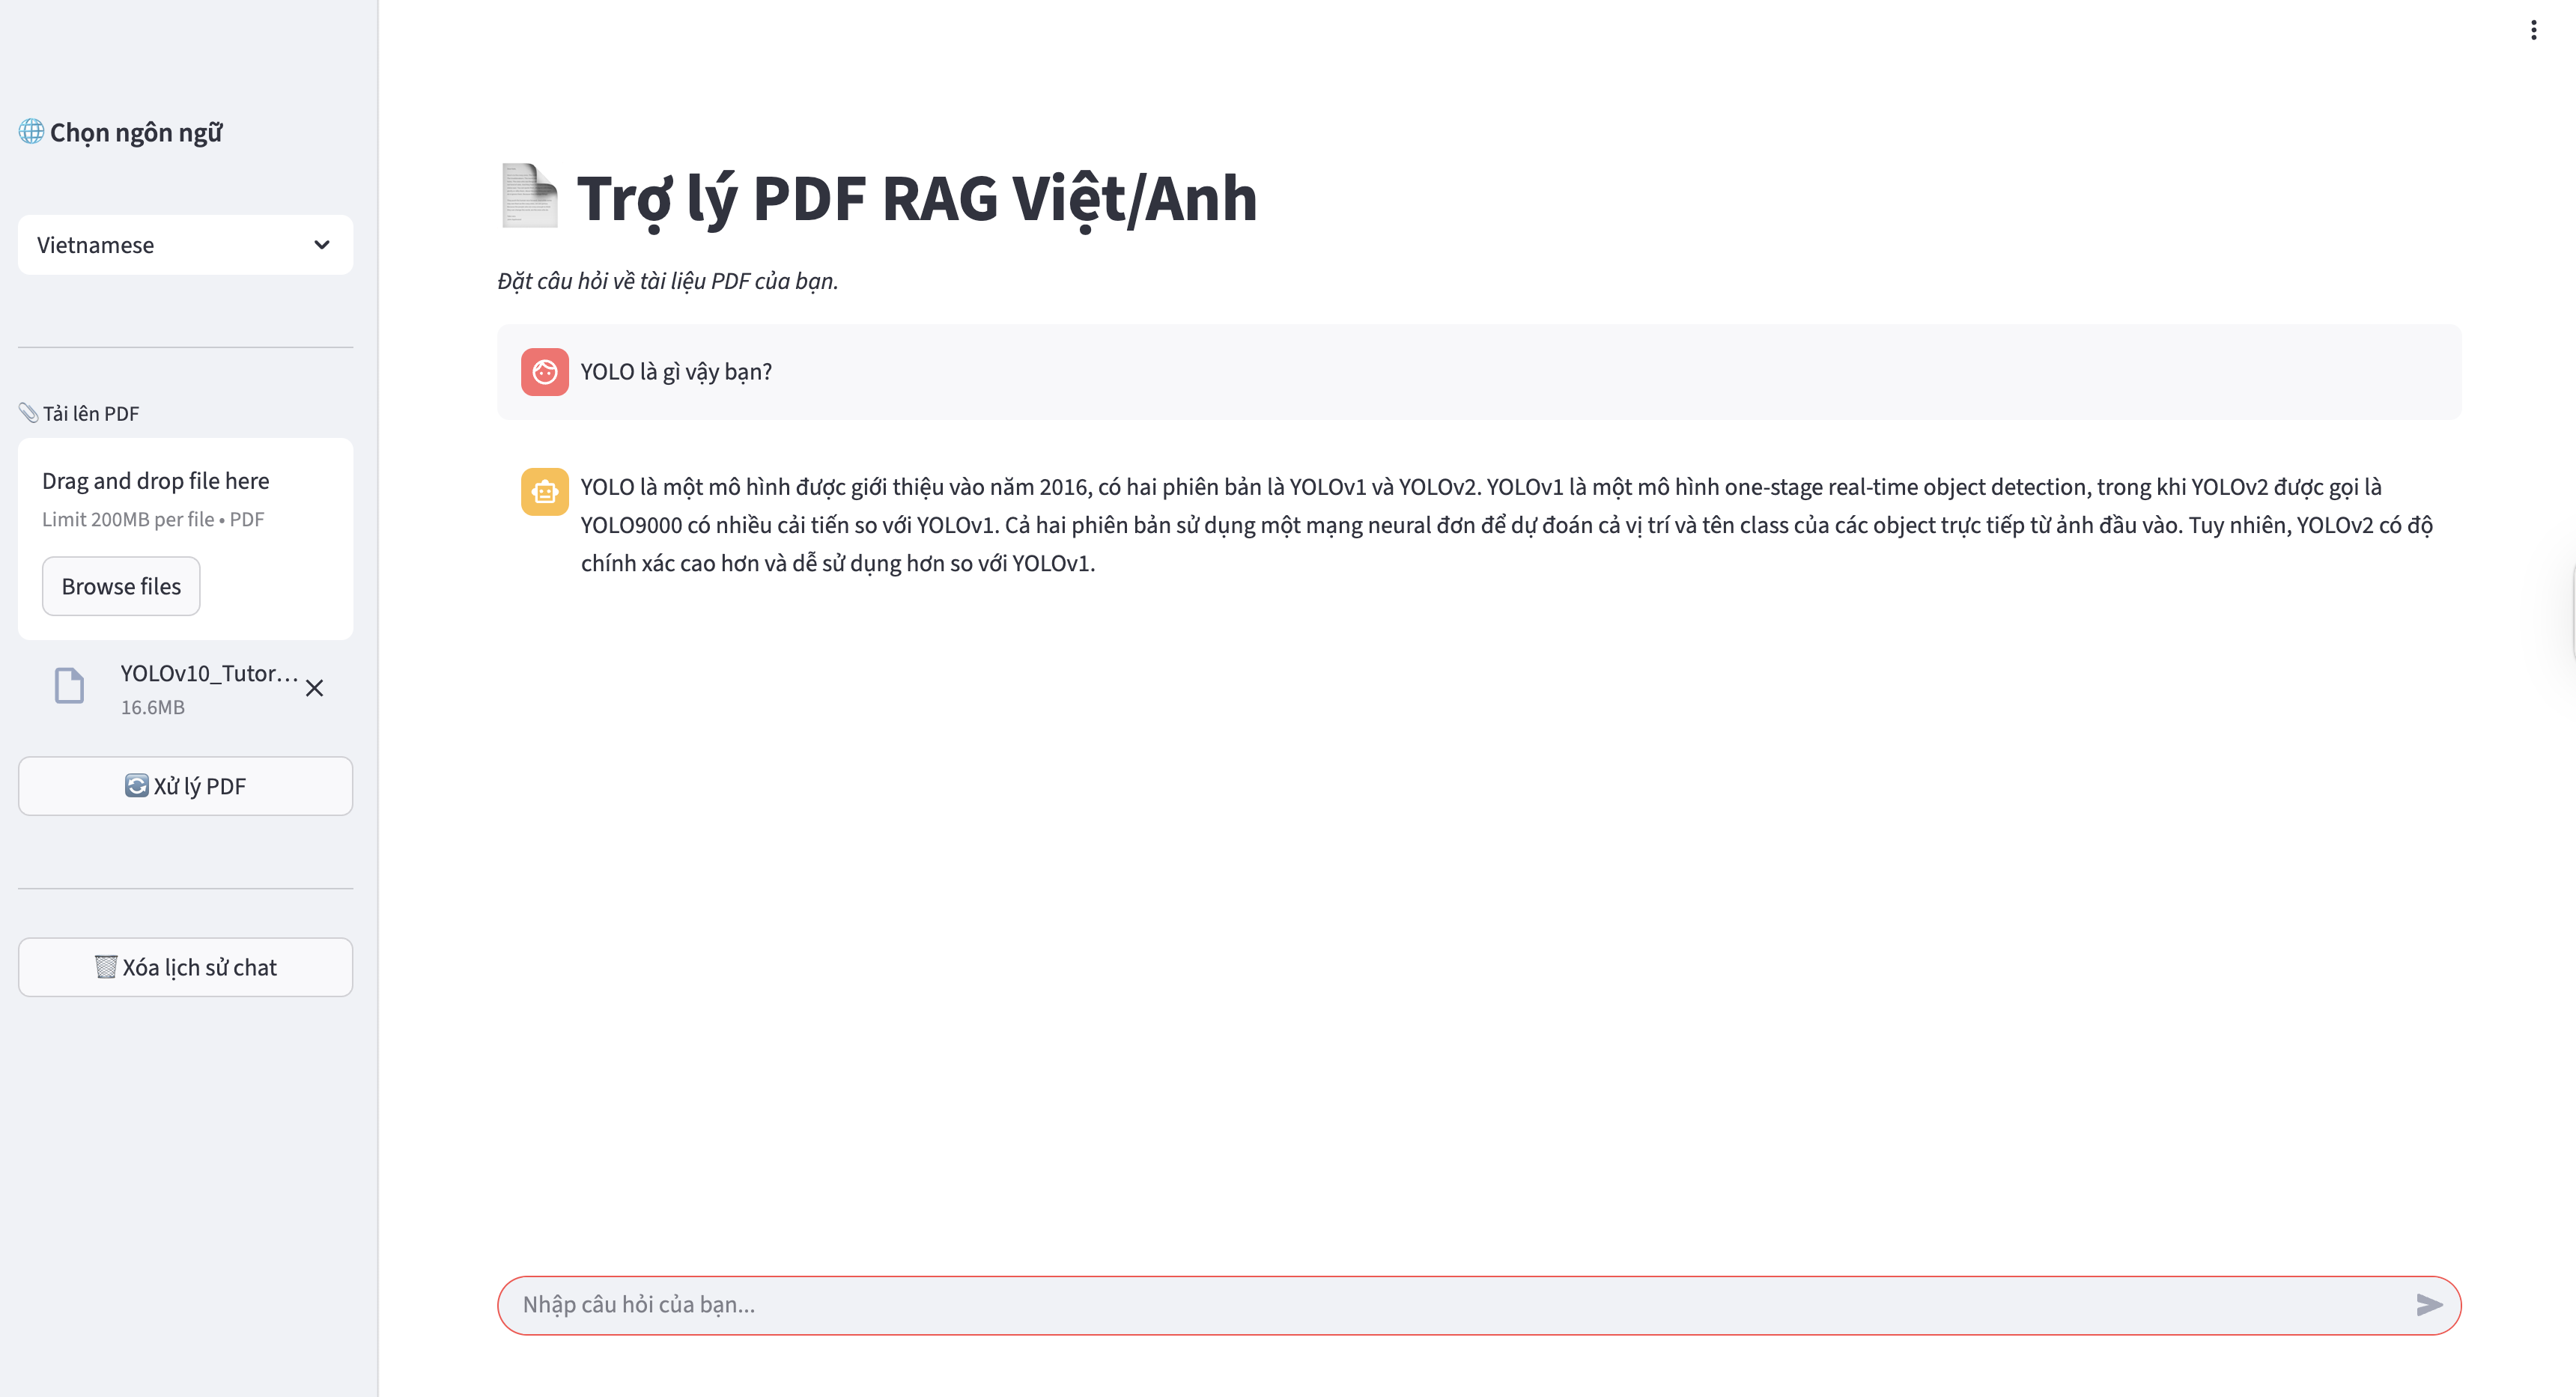

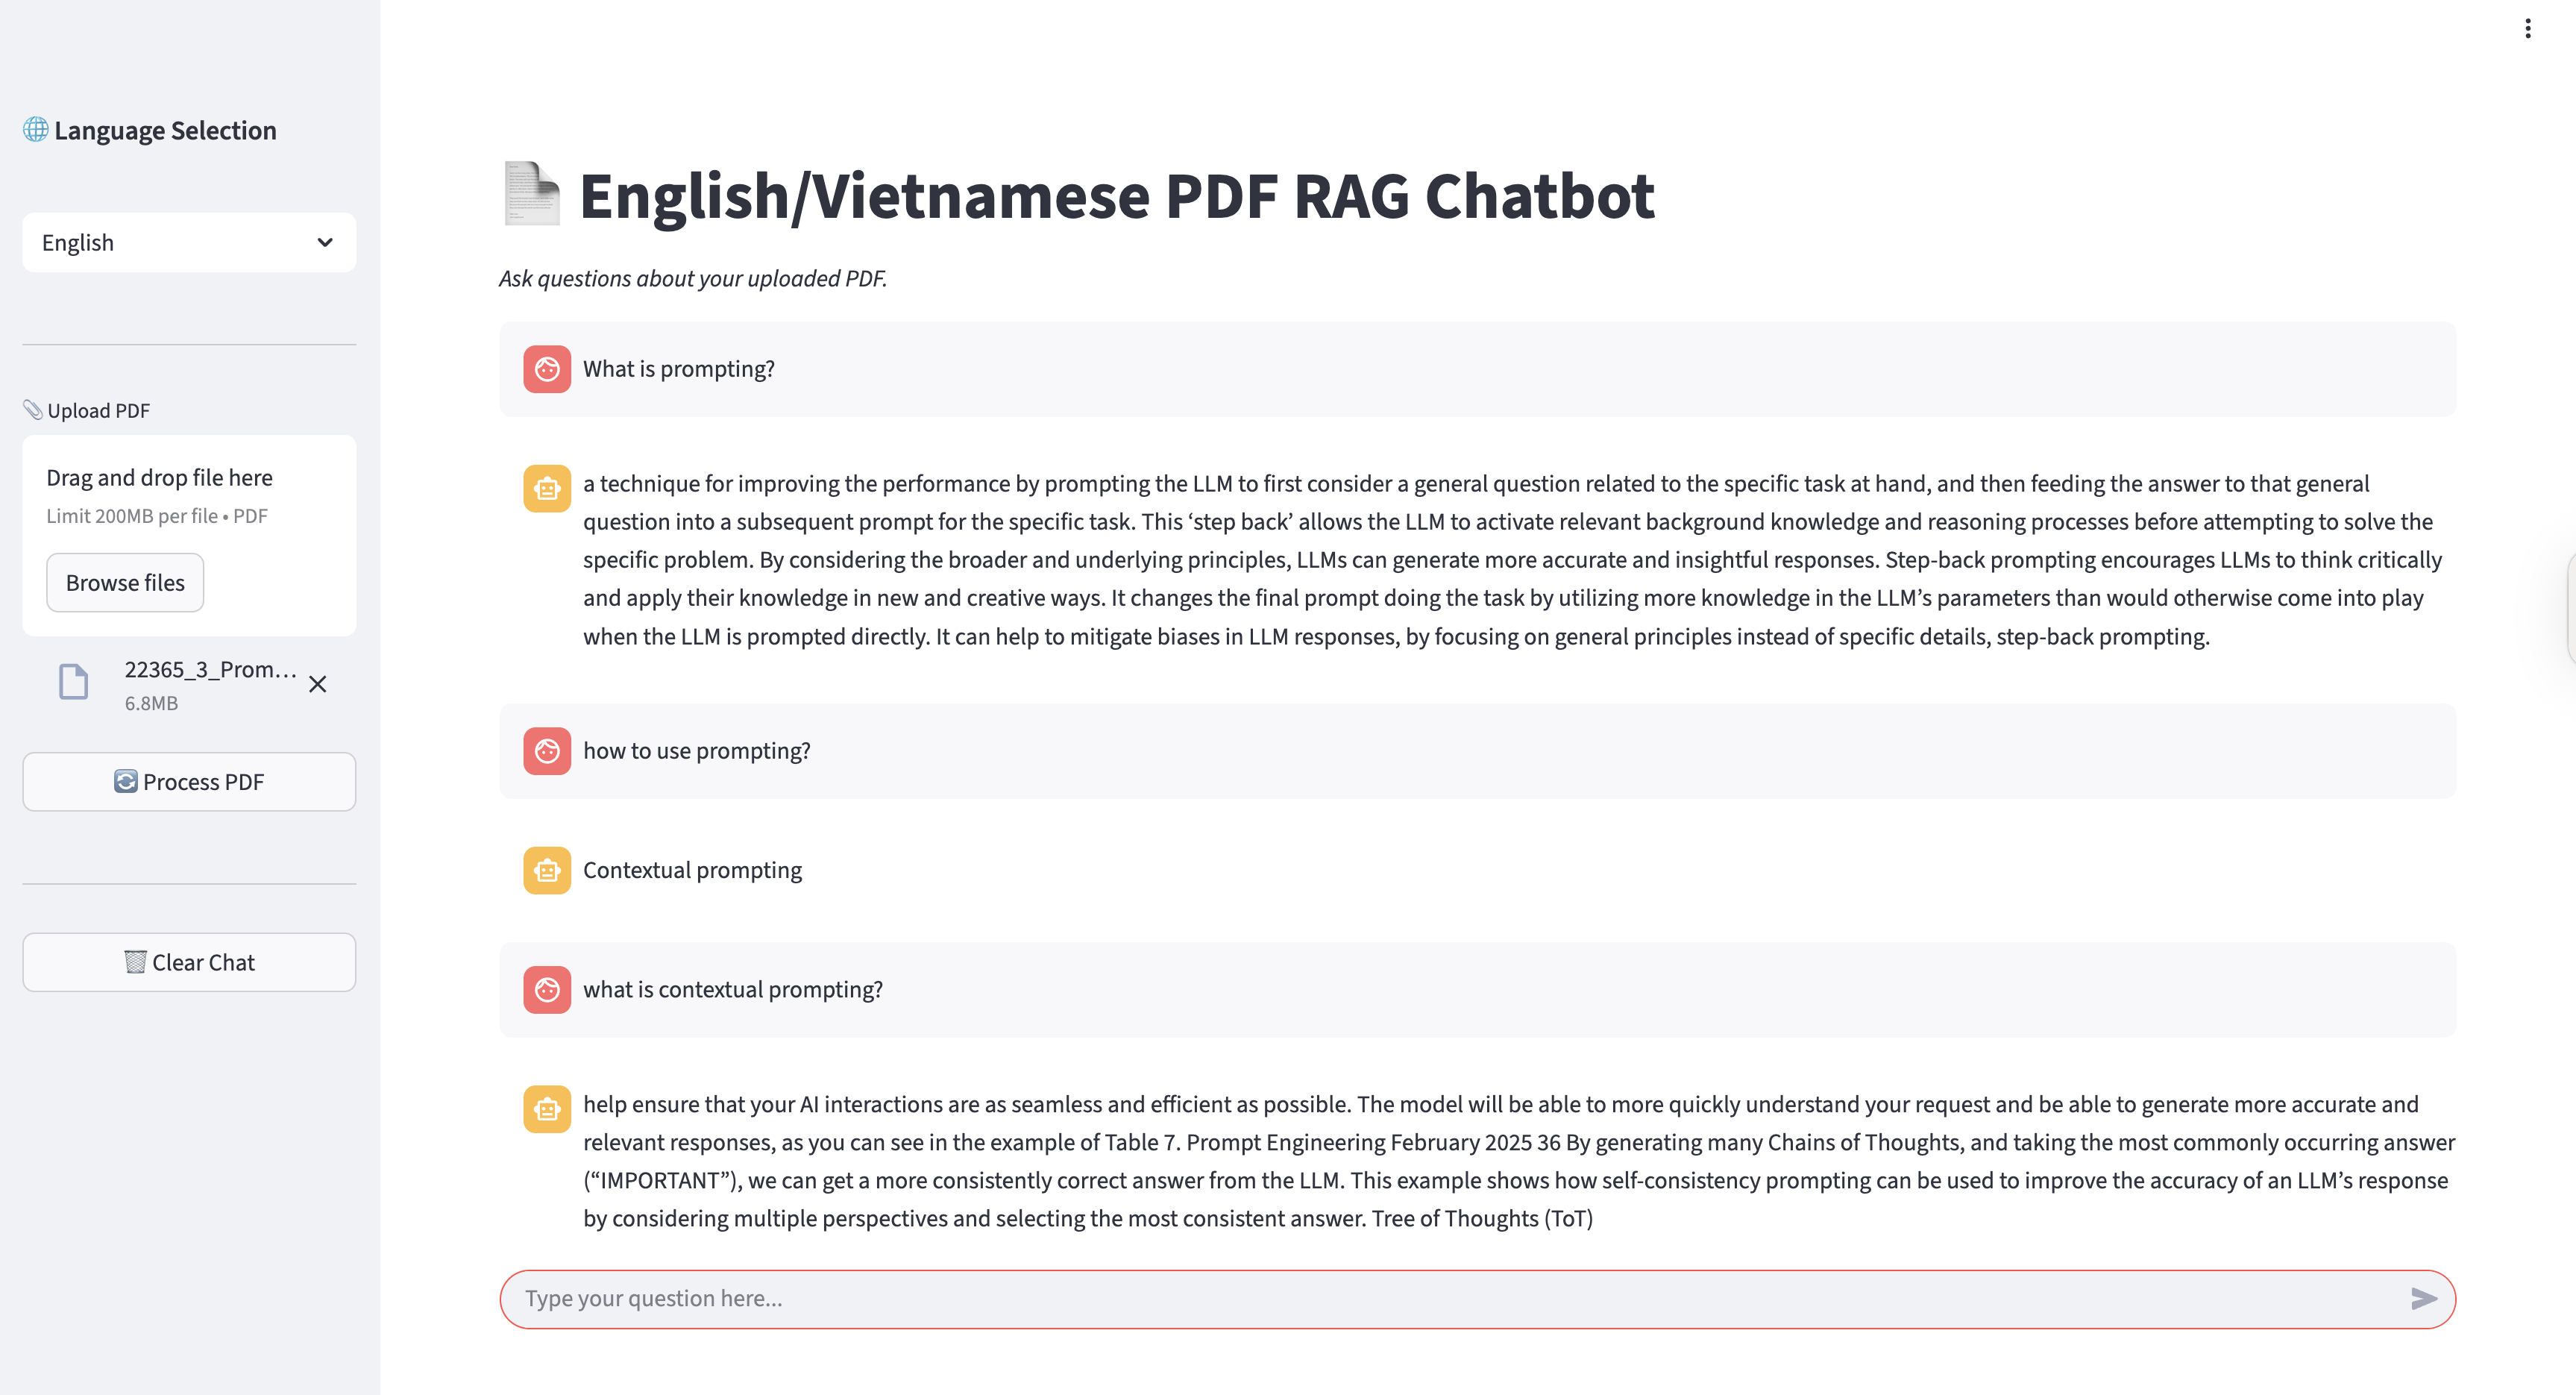